# PD Calibration

## Story
Given details of mortgages and long-term forecasts of macroeconomics factors, we want to forecast long-term PD for mortgages in the portfolio.

## Steps

1. Start from a dataset of the portfolios of loans at the end of each month, and the PD or behavioural scorecard each customer obtained.

2. Decide on the number of cuts 𝑐 to make to the scorecard curve and create the cuts by maximizing differences in PD among cuts with piecewise linear regression

3. Collect a set of macroeconomic regressors at the beginning of each period 𝑡.

4. Run seasonal ARIMAX model so that: 𝑃𝐷𝑡=𝛼𝑃𝐷𝑡−1+𝛽⋅𝑓𝑡−1+𝑒

5. Study the most adequate long term parameters for the vector 𝑓𝑡. Use them to calculate the Long term PD for every segment.

In [1]:
# Package load
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.offsets import MonthEnd
!pip install quandl
import quandl 

%matplotlib inline

# Bigger and prettier plots
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')

In [2]:
# Load and format input data

loans = pd.read_pickle('df_p6.pkl')
loans = loans.sort_values(by='dt_first_pi')
loans['Probs'] = 1-loans['Probs']

In [3]:
# format date for easier join

loans['dt_first_pi'] = pd.to_datetime(loans['dt_first_pi'], format="%Y%m%d") + MonthEnd(1)
loans.columns = ['Default', 'Date', 'Probs']

In [7]:
loans.describe()

,Default,Probs
count,629578.000000,629578.000000
mean,0.024412,0.371044
std,0.154323,0.232102
min,0.000000,0.015071
25%,0.000000,0.174429
50%,0.000000,0.331786
75%,0.000000,0.548612
max,1.000000,0.968109


In [40]:
# Load macroeconomics data from Quandl APIs.

Uemploy = quandl.get("USMISERY/INDEX", authtoken="vLzw95PGzWxzdxHH8htD", collapse="monthly").iloc[:,0]
NHS = quandl.get("FRED/HOUSTNSA", authtoken="vLzw95PGzWxzdxHH8htD", collapse="monthly")
mortgr30 = quandl.get("FMAC/30US", authtoken="vLzw95PGzWxzdxHH8htD", collapse="monthly")

In [60]:
#Format econ data and normalize it for regression models

econ_factors = pd.concat([Uemploy.loc[(Uemploy.index>='2014-02-28')&(Uemploy.index<='2019-08-31')],
                          NHS.loc[(NHS.index>='2014-02-28')&(NHS.index<='2019-08-31')],
                          mortgr30.loc[(mortgr30.index>='2014-02-28')&(mortgr30.index<='2019-08-31')]],
                         axis=1)
econ_factors.columns = ['Unemployment', 'NewHousingStarts', 'MortgageRate30y']
econ_factors = econ_factors.fillna(3.6)
econ_factors

,Unemployment,NewHousingStarts,MortgageRate30y
Date,,,
2014-02-28,6.7,65.1,4.37
2014-03-31,6.7,80.2,4.40
2014-04-30,6.3,94.9,4.33
2014-05-31,6.3,92.5,4.12
2014-06-30,6.1,87.3,4.14
2014-07-31,6.2,101.0,4.12
2014-08-31,6.1,86.2,4.10
2014-09-30,5.9,94.2,4.20
2014-10-31,5.8,92.0,3.98


In [61]:
from scipy.stats import zscore
econ_factors_norm = econ_factors.apply(zscore)
econ_factors_norm

,Unemployment,NewHousingStarts,MortgageRate30y
Date,,,
2014-02-28,2.333193,-2.201212,0.970516
2014-03-31,2.333193,-1.174771,1.057331
2014-04-30,1.855139,-0.175521,0.854762
2014-05-31,1.855139,-0.338664,0.247056
2014-06-30,1.616111,-0.692140,0.304933
2014-07-31,1.735625,0.239134,0.247056
2014-08-31,1.616111,-0.766914,0.189179
2014-09-30,1.377084,-0.223104,0.478563
2014-10-31,1.257570,-0.372652,-0.158081


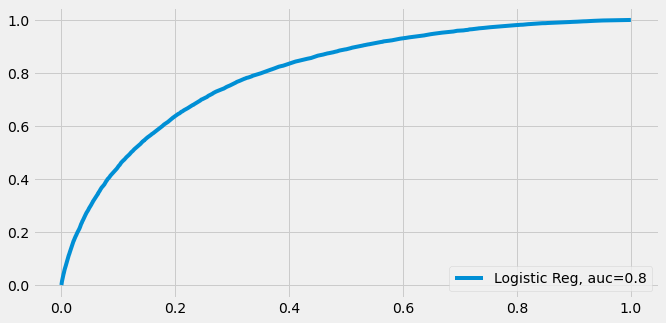

In [8]:
# the AUC curve illustrating the default prediction of input data 

from sklearn.metrics import roc_curve, roc_auc_score

# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(loans['Default'], 
                                 loans['Probs'])

# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = loans['Default'], 
                             y_score = loans['Probs']),
               decimals = 3)

# Create and show the plot
plt.plot(fpr,tpr,label="Logistic Reg, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [9]:
# Install package for piecewise linear regression

!pip install pwlf

In [142]:
import pwlf

# Define the curve with the ROC curve
piecewise_AUC = pwlf.PiecewiseLinFit(fpr, tpr)

# Calculate the best curve. 
res = piecewise_AUC.fit(15)

/opt/conda/lib/python3.8/site-packages/pwlf/pwlf.py:1108: RuntimeWarning: invalid value encountered in double_scalars
  self.slopes[i] = (y_hat[i+1]-y_hat[i]) / \


In [143]:
# the result of the most fitted piecewise regression regarding the original AUC curve (the closest linear partition)

res

array([0.        , 0.00571401, 0.02076842, 0.04886299, 0.08795348,
       0.09231967, 0.13454708, 0.21897408, 0.30354359, 0.39510661,
       0.46323867, 0.53552568, 0.62178932, 0.74346939, 0.84623313,
       1.        ])

array([0.        , 0.00571401, 0.02076842, 0.04886299, 0.08795348,
       0.09231967, 0.13454708, 0.21897408, 0.30354359, 0.39510661,
       0.46323867, 0.53552568, 0.62178932, 0.74346939, 0.84623313,
       1.        ])

In [12]:
cuts = piecewise_AUC.fit_with_breaks(res)

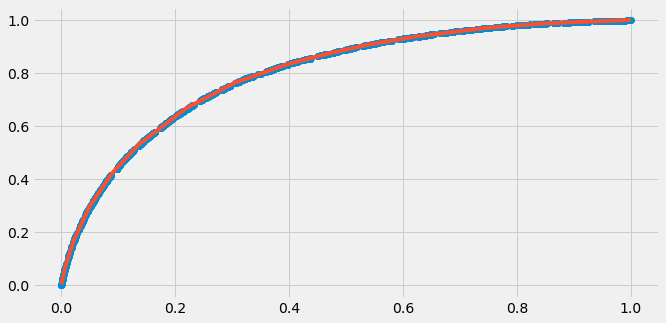

In [144]:
# predict for the determined points
xHat = np.linspace(min(fpr), max(fpr), num=10000)
yHat = piecewise_AUC.predict(xHat)

# plot the results
plt.figure()
plt.plot(fpr, tpr, 'o')
plt.plot(xHat, yHat, '-')
plt.show()

In [145]:
pd_cut = pd.cut(loans['Probs'], res)
pd_cut

13507      (0.0923, 0.135]
7279        (0.304, 0.395]
49477      (0.0489, 0.088]
2933        (0.395, 0.463]
45743       (0.743, 0.846]
                ...       
2016769     (0.463, 0.536]
2098567     (0.743, 0.846]
2016786     (0.743, 0.846]
1923227     (0.304, 0.395]
2098590     (0.135, 0.219]
Name: Probs, Length: 629578, dtype: category
Categories (15, interval[float64]): [(0.0, 0.00571] < (0.00571, 0.0208] < (0.0208, 0.0489] < (0.0489, 0.088] ... (0.536, 0.622] < (0.622, 0.743] < (0.743, 0.846] < (0.846, 1.0]]

In [146]:
# Create table with cases total.
PDs_Tab = pd.crosstab(pd_cut,
                      loans['Default'],
                      normalize = False)

# Calculate default rate.
print(PDs_Tab)
pd_final = PDs_Tab[1] / (PDs_Tab[0] + PDs_Tab[1])
pd_final

Default                0     1
Probs                         
(0.00571, 0.0208]   1944     2
(0.0208, 0.0489]   13856    10
(0.0489, 0.088]    38547    74
(0.088, 0.0923]     9541    27
(0.0923, 0.135]    48267   138
(0.135, 0.219]     93081   495
(0.219, 0.304]     78282   672
(0.304, 0.395]     82391  1073
(0.395, 0.463]     51212   925
(0.463, 0.536]     44470  1162
(0.536, 0.622]     52023  1919
(0.622, 0.743]     53082  2924
(0.743, 0.846]     33470  3286
(0.846, 1.0]       14043  2662


Probs
(0.00571, 0.0208]    0.001028
(0.0208, 0.0489]     0.000721
(0.0489, 0.088]      0.001916
(0.088, 0.0923]      0.002822
(0.0923, 0.135]      0.002851
(0.135, 0.219]       0.005290
(0.219, 0.304]       0.008511
(0.304, 0.395]       0.012856
(0.395, 0.463]       0.017742
(0.463, 0.536]       0.025465
(0.536, 0.622]       0.035575
(0.622, 0.743]       0.052209
(0.743, 0.846]       0.089400
(0.846, 1.0]         0.159353
dtype: float64

In [160]:
# Adjusted cuts for any non-monotonicity
res = [0.04886299, 
       0.13454708, 0.21897408, 0.30354359, 0.62178932, 0.74346939, 0.84623313,
       1.        ]

# Add the PDCut variable to our dataframe
loans['PD_Cut'] = pd.cut(loans['Probs'], res)

# Create pivot table
PD_monthly = pd.pivot_table(loans,
                            values = 'Default',
                            index = 'Date',
                            columns = 'PD_Cut',
                            aggfunc = np.mean
                            )

PD_monthly = PD_monthly.fillna(0)
pd.set_option('display.max_rows', 500)
PD_monthly

PD_Cut,"(0.0489, 0.135]","(0.135, 0.219]","(0.219, 0.304]","(0.304, 0.622]","(0.622, 0.743]","(0.743, 0.846]","(0.846, 1.0]"
Date,,,,,,,
2014-02-28,0.000000,0.076923,0.000000,0.045455,0.250000,0.333333,0.000000
2014-03-31,0.003584,0.016706,0.015129,0.047423,0.098734,0.167331,0.288136
2014-04-30,0.006098,0.009143,0.022989,0.032145,0.106291,0.147368,0.270492
2014-05-31,0.007360,0.008964,0.020293,0.041667,0.071429,0.139785,0.226190
2014-06-30,0.005761,0.014060,0.009730,0.030154,0.097059,0.138015,0.221053
2014-07-31,0.005113,0.008361,0.020290,0.039160,0.100000,0.138702,0.213115
2014-08-31,0.002513,0.010237,0.018745,0.030460,0.078704,0.109489,0.191837
2014-09-30,0.002323,0.008360,0.013375,0.033702,0.089422,0.137363,0.233333
2014-10-31,0.003104,0.008491,0.016962,0.031025,0.079596,0.123675,0.222672


In [161]:
# no data after 2019-02-28, there discard rows after
PD_monthly = PD_monthly.loc[PD_monthly.index <= '2019-02-28']
PD_monthly

PD_Cut,"(0.0489, 0.135]","(0.135, 0.219]","(0.219, 0.304]","(0.304, 0.622]","(0.622, 0.743]","(0.743, 0.846]","(0.846, 1.0]"
Date,,,,,,,
2014-02-28,0.000000,0.076923,0.000000,0.045455,0.250000,0.333333,0.000000
2014-03-31,0.003584,0.016706,0.015129,0.047423,0.098734,0.167331,0.288136
2014-04-30,0.006098,0.009143,0.022989,0.032145,0.106291,0.147368,0.270492
2014-05-31,0.007360,0.008964,0.020293,0.041667,0.071429,0.139785,0.226190
2014-06-30,0.005761,0.014060,0.009730,0.030154,0.097059,0.138015,0.221053
2014-07-31,0.005113,0.008361,0.020290,0.039160,0.100000,0.138702,0.213115
2014-08-31,0.002513,0.010237,0.018745,0.030460,0.078704,0.109489,0.191837
2014-09-30,0.002323,0.008360,0.013375,0.033702,0.089422,0.137363,0.233333
2014-10-31,0.003104,0.008491,0.016962,0.031025,0.079596,0.123675,0.222672


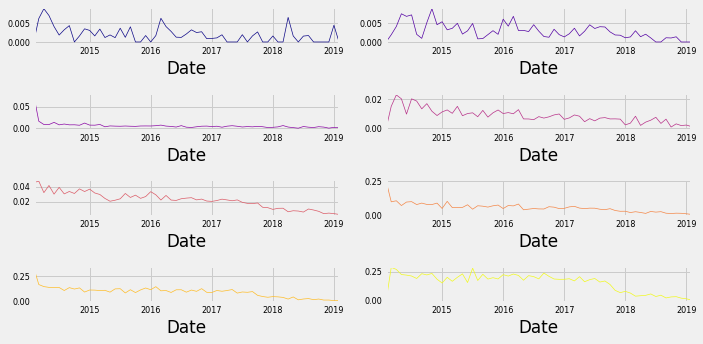

In [156]:
# plot time series curve of default rate for each PD group. 

PD_monthly.plot(subplots=True,
          layout=(4, 2),
          sharex=False,
          sharey=False,
          colormap='plasma',
         fontsize=8,
         legend=False,
         linewidth=0.7);
plt.tight_layout();

# Estimating Long-Term PD

In [19]:
PD_monthly = PD_monthly.asfreq('m')

In [150]:
PD_monthly

PD_Cut,"(0.0489, 0.088]","(0.088, 0.135]","(0.135, 0.219]","(0.219, 0.304]","(0.304, 0.395]","(0.395, 0.463]","(0.463, 0.536]","(0.536, 0.622]","(0.622, 0.743]","(0.743, 0.846]","(0.846, 1.0]"
Date,,,,,,,,,,,
2014-02-28,0.000000,0.000000,0.076923,0.000000,0.000000,0.000000,0.000000,0.333333,0.250000,0.333333,0.000000
2014-03-31,0.006270,0.001931,0.016706,0.015129,0.033803,0.037862,0.041056,0.084091,0.098734,0.167331,0.288136
2014-04-30,0.008902,0.004141,0.009143,0.022989,0.016736,0.014634,0.035714,0.067797,0.106291,0.147368,0.270492
2014-05-31,0.007075,0.007541,0.008964,0.020293,0.016736,0.028146,0.063462,0.075658,0.071429,0.139785,0.226190
2014-06-30,0.004124,0.006849,0.014060,0.009730,0.025618,0.016584,0.032986,0.050000,0.097059,0.138015,0.221053
2014-07-31,0.001848,0.007246,0.008361,0.020290,0.018010,0.043413,0.034539,0.074392,0.100000,0.138702,0.213115
2014-08-31,0.003263,0.002043,0.010237,0.018745,0.014728,0.027778,0.035817,0.054282,0.078704,0.109489,0.191837
2014-09-30,0.004380,0.000964,0.008360,0.013375,0.018574,0.032413,0.043353,0.051313,0.089422,0.137363,0.233333
2014-10-31,0.000000,0.005187,0.008491,0.016962,0.021610,0.031008,0.036496,0.042027,0.079596,0.123675,0.222672


<ipython-input-90-655b83f16cdd>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition = seasonal_decompose(PD_monthly.values, freq=12, model='additive')


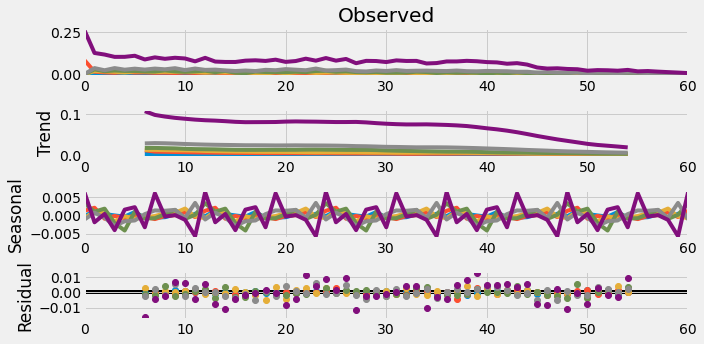

In [90]:
# decompose seasonal effect.

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(PD_monthly.values, freq=12, model='additive')
fig = decomposition.plot()
plt.show()

In [22]:
import operator
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [91]:
def find_optimal_param(y): 
    
    '''
    this is a function for SARIMAX grid search

    '''




    # Define the search space.
    p = range(1, 7)
    d = range(0, 2)
    q = range(0, 2)

    # Create an interative list of ps, ds, qs.
    from itertools import product
    pdq = list(product(p, d, q))

    # Seasonal parameters. One year back.
    ps = range(0, 2)
    ds = range(0, 2)
    qs = range(0, 2)
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(ps, ds, qs))]
    
    ef = econ_factors_norm.iloc[econ_factors_norm.index <= '2019-02-28']
    

    dic_param = []

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            mod = SARIMAX(PD_monthly.iloc[:, y].tolist(),
                        exog=np.asarray(ef),
                        order=param,
                        seasonal_order=param_seasonal,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
            results = mod.fit()

            dic_param.append((param, param_seasonal, results.bic))

    #       print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
    return min(dic_param, key=operator.itemgetter(2))

In [24]:
# enable parallel for faster operations

import multiprocessing

In [131]:
def driver_func(ls):
    PROCESSES = 14
    with multiprocessing.Pool(PROCESSES) as pool:
        
        fidx = [(h, ) for h in ls]

        results = [pool.apply_async(find_optimal_param, y) for y in fidx]

        return [r.get() for r in results]

In [ ]:
a = driver_func(range(len(res)-1))

In [163]:
# Table shows the optimal model parameters for each group. From top to bottom, we can call them AAA, AA+, A+, BBB+, BB+, B+, CCC+, respectively in Standard & Poor’s terms.

a

[((1, 0, 0), (0, 0, 0, 12), -601.0769212590061),
 ((1, 1, 1), (0, 0, 0, 12), -553.9996505282644),
 ((1, 0, 1), (0, 0, 0, 12), -517.128978050434),
 ((2, 0, 1), (0, 0, 0, 12), -485.71682622942916),
 ((1, 0, 1), (0, 0, 0, 12), -330.98441909333906),
 ((1, 0, 1), (0, 0, 0, 12), -297.99107999386524),
 ((2, 1, 0), (0, 0, 0, 12), -235.5805448315437)]

In [65]:
# Find long run estimate of all macroeconomics factors.

longrun_ef = np.array([5.7, 1320/12, 1.7]) # hardcoded from forecast reports obtained from RBC Economics.
mean_ef = np.array([np.mean(econ_factors.iloc[:,0]), np.mean(econ_factors.iloc[:,1]), np.mean(econ_factors.iloc[:,2])])
std_ef = np.array([np.std(econ_factors.iloc[:,0]), np.std(econ_factors.iloc[:,1]), np.std(econ_factors.iloc[:,2])])
longrun_ef_norm = (longrun_ef - mean_ef)/std_ef
longrun_ef_norm

array([ 1.13805615,  0.85092025, -6.75603388])

In [75]:
def forecast_pd(p, y):
    '''
    This is a function for SARIMAX forecasting.
    '''

    ef = econ_factors_norm.iloc[econ_factors_norm.index <= '2019-02-28']
    mod = SARIMAX(PD_monthly.iloc[:, y].tolist(),
                  exog=np.asarray(ef),
                  order=p[0],
                  seasonal_order=p[1],
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    results = mod.fit()
    return results.forecast(exog=longrun_ef_norm)

In [164]:
# Calculate the longterm forecast for each PD group.

cali_pd = []
for m, n in zip(a, range(len(res)-1)):
    cali_pd.append(forecast_pd(m, n))
cali_pd

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[array([0.00031181]),
 array([0.00311645]),
 array([0.0048231]),
 array([0.01277154]),
 array([0.01306377]),
 array([0.02723113]),
 array([0.14473844])]

In [30]:
# forecast diagnoses.

def forecast_diagnos(p, y):
    '''
    This is a function generating diagnosis for each model.
    '''

    ef = econ_factors_norm.iloc[econ_factors_norm.index <= '2019-02-28']
    mod = SARIMAX(PD_monthly.iloc[:, y].tolist(),
                  exog=np.asarray(ef),
                  order=p[0],
                  seasonal_order=p[1],
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    results = mod.fit()
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


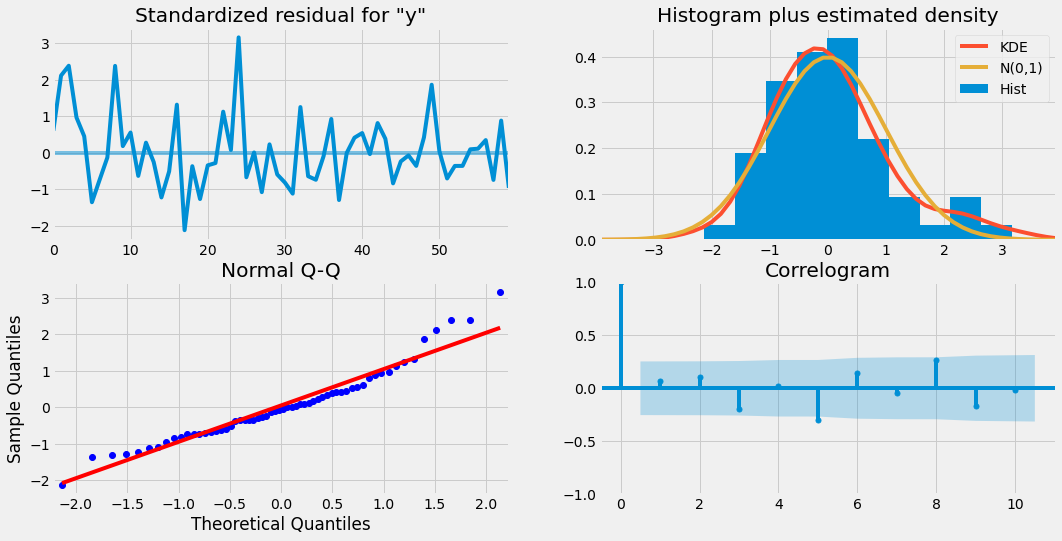

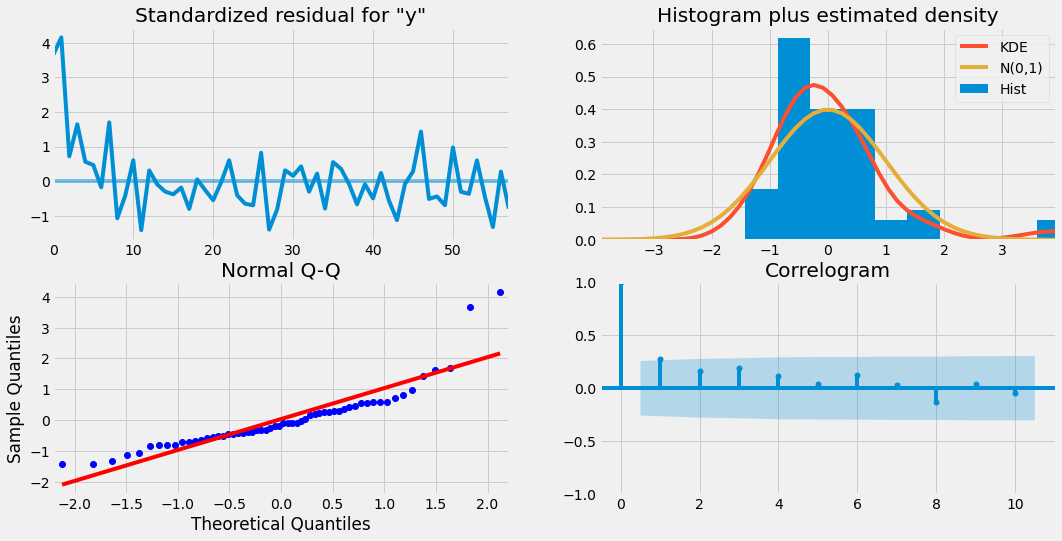

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


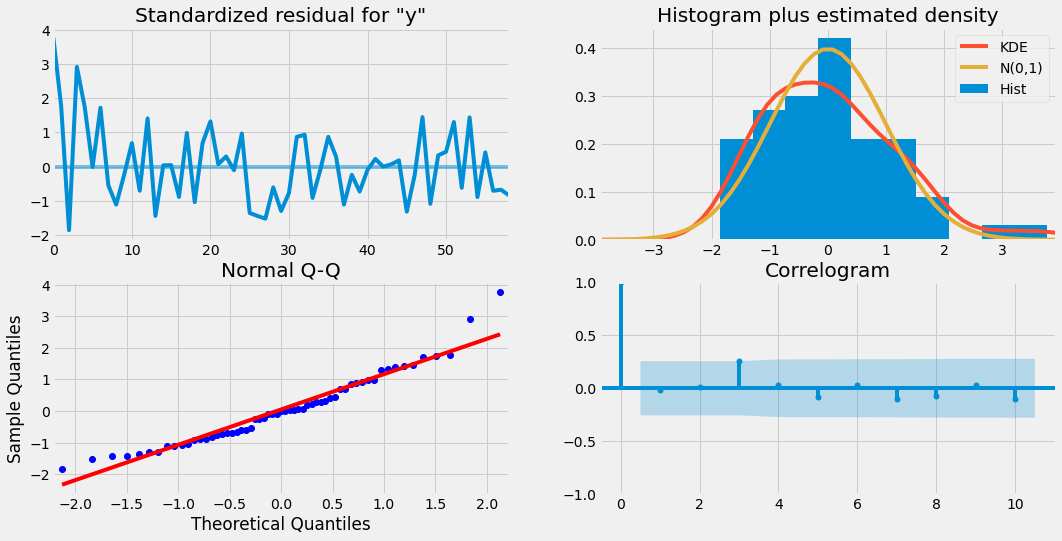

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


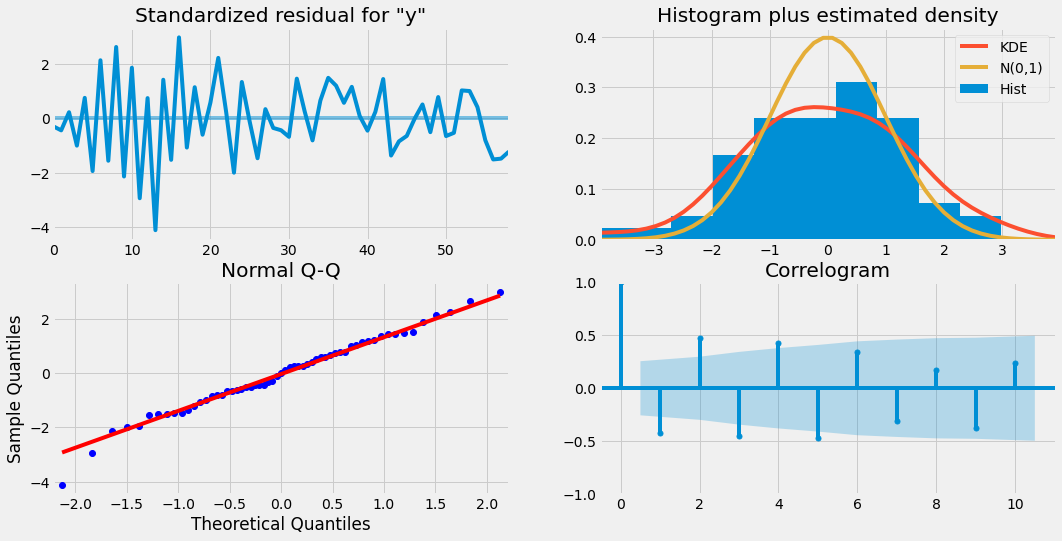

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


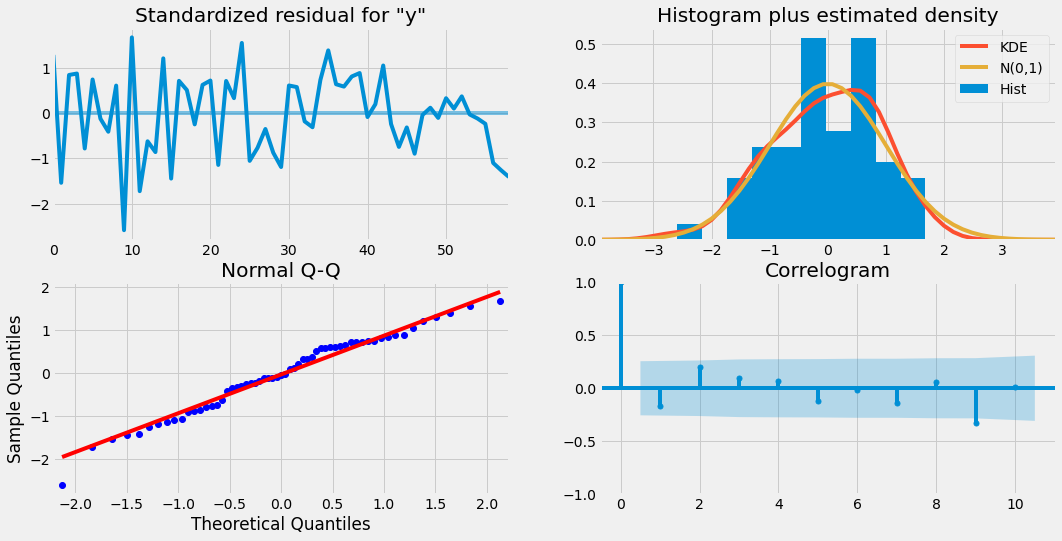

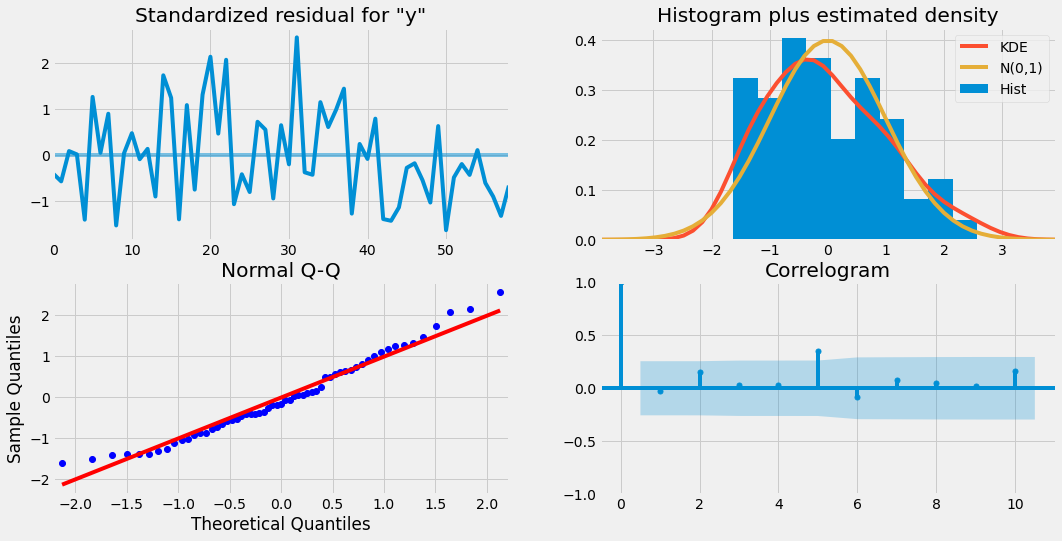

/opt/conda/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


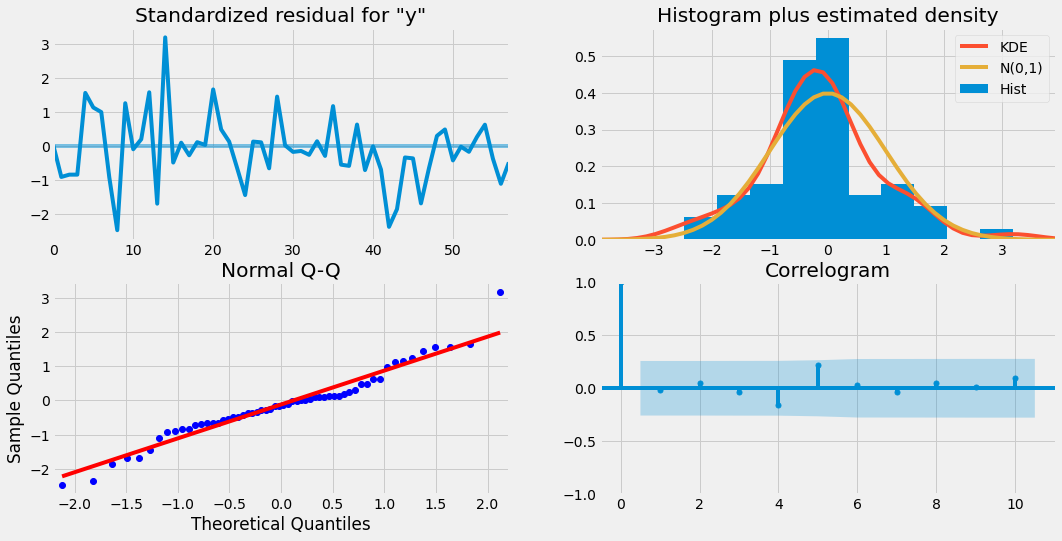

In [165]:
#check the diagnoses of each SARIMAX model to ensure the validity of my model. As shown in Graph 6.8, most diagnoses perform well. For example, the standardized residue looks random, the KDE does not deviate too much from a stand normal bell curve, a good fit QQ plot and a correlogram without too many significant lags. The only exception is the fourth cut, whose standard residue seems correlated for the first few months. Its KDE curve also presents too much fucus around mean, meaning that it has a how peak and thin tails. The correlogram reveals that there exist lagged autocorrelations

for m, n in zip(a, range(len(res)-1)):
    forecast_diagnos(m, n)